In [17]:
# 导入 pandas 包。Pandas 是一个用于数据处理和分析的 Python 库
# 提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd
# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken
import os

basePath = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
#读取fine_food_reviews_1k.csv文件
input_data_path = basePath +'/data/fine_food_reviews_1k.csv'
df = pd.read_csv(input_data_path,index_col=0)
#删除缺失值
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()



# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
#显示前2条数据
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [10]:
#打印组合后的combined数据
df["combined"]

0      Title: where does one  start...and stop... wit...
1      Title: Arrived in pieces; Content: Not pleased...
2      Title: It isn't blanc mange, but isn't bad . ....
3      Title: These also have SALT and it's not sea s...
4      Title: Happy with the product; Content: My dog...
                             ...                        
995    Title: Delicious!; Content: I have ordered the...
996    Title: Good Training Treat; Content: My dog wi...
997    Title: Jamica Me Crazy Coffee; Content: Wolfga...
998    Title: Party Peanuts; Content: Great product f...
999    Title: I love Maui Coffee!; Content: My first ...
Name: combined, Length: 1000, dtype: object

In [11]:
# 模型类型
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000

In [12]:
# 设置要筛选的评论数量为1000
top_n = 1000
# 对DataFrame进行排序，基于"Time"列，然后选取最后的2000条评论。
# 这个假设是，我们认为最近的评论可能更相关，因此我们将对它们进行初始筛选。
df = df.sort_values("Time").tail(top_n * 2) 
# 丢弃"Time"列，因为我们在这个分析中不再需要它。
df.drop("Time", axis=1, inplace=True)
# 从'embedding_encoding'获取编码
encoding = tiktoken.get_encoding(embedding_encoding)

# 计算每条评论的token数量。我们通过使用encoding.encode方法获取每条评论的token数，然后把结果存储在新的'n_tokens'列中。
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

# 如果评论的token数量超过最大允许的token数量，我们将忽略（删除）该评论。
# 我们使用.tail方法获取token数量在允许范围内的最后top_n（1000）条评论。
df = df[df.n_tokens <= max_tokens].tail(top_n)

# 打印出剩余评论的数量。
len(df)

1000

In [13]:

df["combined"]

0      Title: where does one  start...and stop... wit...
297    Title: Good, but not Wolfgang Puck good; Conte...
296    Title: Should advertise coconut as an ingredie...
295    Title: Best tomato soup; Content: I have a har...
294    Title: Should advertise coconut as an ingredie...
                             ...                        
623    Title: Strange inflammation response; Content:...
624    Title: My favorite and only  MUSTARD; Content:...
625    Title: My furbabies LOVE these!; Content: Shak...
619    Title: got this for the daughter; Content: all...
999    Title: I love Maui Coffee!; Content: My first ...
Name: combined, Length: 1000, dtype: object

In [14]:
from openai import OpenAI
import os
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt, retry_if_not_exception_type

client = OpenAI(
    base_url=os.getenv("OPENAI_BASE_URL"),
    api_key=os.getenv("OPENAI_API_KEY"),
)
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6), retry=retry_if_not_exception_type(openai.BadRequestError))
def get_model_embedding(text: str, model: str = "text-embedding-ada-002") -> list[float]:
    """Get the embedding for a given text using the OpenAI API."""
    response = client.embeddings.create(
        input=text,
        model=model,
    )
    return response.data[0].embedding
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6), retry=retry_if_not_exception_type(openai.BadRequestError))
def get_embeddings(text: list[str], model: str = "text-embedding-ada-002") -> list[list[float]]:
    response = client.embeddings.create(input=text, 
                             model=model,
                             )
    return   [item.embedding for item in response.data]

print(get_model_embedding(text='abc'))


[0.002615210600197315, -0.011296011507511139, -0.00963275134563446, -0.039097219705581665, -0.03448256105184555, 0.012145334854722023, -0.021303880959749222, -0.02280435338616371, 0.018685130402445793, -0.00038153232890181243, 0.0033760634250938892, 0.019194725900888443, -0.0026983735151588917, -0.004526189994066954, -0.018840840086340904, 0.0029708649963140488, 0.027093440294265747, 0.010666095651686192, 0.010800572112202644, 0.007530673872679472, -0.014537598006427288, 0.01776503026485443, -0.0069786133244633675, -0.01562756486237049, -0.020199758931994438, -0.003558314172551036, 0.009993714280426502, -0.020058205351233482, 0.026272427290678024, -0.007325420621782541, 0.00774300517514348, 0.013787361793220043, -0.007459897082298994, -0.009944169782102108, -0.010397142730653286, -0.014219101518392563, -0.013645808212459087, -0.015924828127026558, 0.010382987558841705, -0.00026408673147670925, 0.024347292259335518, 0.0045155733823776245, 0.014098781161010265, -0.022960063070058823, -0.

In [15]:
# df["embedding"] = df.combined.apply(get_model_embedding())

# output_datapath = "data/fine_food_reviews_with_embeddings_1k_1126.csv"

# df.to_csv(output_datapath)
#返回嵌入向量
type(get_model_embedding(text='123'))

list

In [16]:
df = df.head(20)

df["embedding"] = df.combined.apply(get_model_embedding)

df


,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007000929210335016, -0.027453815564513206, ..."
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.003435301361605525, -0.010012203827500343,..."
296,B008JKTTUA,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[-0.017644274979829788, -7.453539728885517e-05..."
295,B000LKTTTW,A14MQ40CCU8B13,5,Best tomato soup,I have a hard time finding packaged food of an...,Title: Best tomato soup; Content: I have a har...,111,"[-0.0013070856221020222, -0.011090422980487347..."
294,B001D09KAM,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[-0.017644274979829788, -7.453539728885517e-05..."
293,B001D09KAM,A1XV4W7JWX341C,5,"Loved these gluten free healthy bars, saved $$...",These Kind Bars are so good and healthy & glut...,"Title: Loved these gluten free healthy bars, s...",96,"[-0.0023114713840186596, -0.013186425901949406..."
292,B002JA06Z8,A3ESIUM1JTR7KK,5,These fresh berries are truly MIRACULOUS!!!,I have ordered from Ethans on three separate o...,Title: These fresh berries are truly MIRACULOU...,98,"[-0.015383286401629448, -0.03547737002372742, ..."
291,B002HQNCBO,A1UW65ZMZ3UWD3,5,Baconnaise,If you are a fan of bacon you're going to like...,Title: Baconnaise; Content: If you are a fan o...,44,"[-0.020563902333378792, 0.00011261481267865747..."
290,B008JKTTUA,A1XV4W7JWX341C,5,"Loved these gluten free healthy bars, saved $$...",These Kind Bars are so good and healthy & glut...,"Title: Loved these gluten free healthy bars, s...",96,"[-0.0023678855504840612, -0.013224039226770401..."
289,B0048GRNZM,AXG287OY16WWL,1,Cute,"For some reason I thought that you got three ""...",Title: Cute; Content: For some reason I though...,77,"[-0.021290812641382217, -0.0003628348640631884..."


In [17]:
output_datapath = basePath+"/data/fine_food_reviews_1k_0325.csv"

df.to_csv(output_datapath)

In [18]:
embedding_datapath = basePath+"/data/fine_food_reviews_with_embeddings_1k.csv"

df_embedded = pd.read_csv(embedding_datapath, index_col=0)

df_embedded['embedding']

12     [-0.0005399271612986922, -0.004124758299440145...
13     [0.0068963742814958096, 0.0167608093470335, -0...
14     [-0.0023715533316135406, -0.021357767283916473...
15     [0.00226533692330122, 0.010306870564818382, 0....
16     [-0.027459919452667236, -0.009041198529303074,...
                             ...                        
447    [0.00796585250645876, 0.0017102764686569571, 0...
436    [0.001777207711711526, -0.011673098430037498, ...
437    [-0.005498920567333698, -0.014834611676633358,...
438    [-0.00294404081068933, -0.007058987859636545, ...
439    [-0.006043732166290283, -0.000693734094966203,...
Name: embedding, Length: 1000, dtype: object

In [19]:
len(df_embedded["embedding"][0])

34410

In [20]:
#字符串类型  pandas.core.series.Series str
type(df_embedded['embedding'][0])

str

In [21]:
len(df_embedded["embedding"][297])

34722

In [55]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

(len(df_embedded["embedding_vec"][0]))

1536

In [23]:
type(df_embedded["embedding_vec"][0])


list

In [24]:
len(df_embedded["embedding_vec"][0])

1536

In [25]:
df_embedded.head(2)


,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145..."
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0..."


In [26]:
type(df_embedded["embedding_vec"][0])

list

In [63]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [28]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [29]:
# 首先，确保你的嵌入向量都是等长的
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

In [56]:

len(df_embedded['embedding_vec'][0])

1536

In [61]:
# 将嵌入向量列表转换为二维 numpy 数组
df_embedded['embedding_vec'].values
matrix = np.vstack(df_embedded['embedding_vec'].values)

#matrix_embedded = np.vstack(df_embedded['embedding'].values)
print("行数：",len(matrix))
print("列数：",len(matrix[0]))

行数： 1000
列数： 1536


In [32]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)


In [33]:
if df_embedded['embedding_vec'].values is None:
    print("df_embedded['embedding_vec'].values 是 None")
else:
    print("df_embedded['embedding_vec'].values 不是 None")


df_embedded['embedding_vec'].values 不是 None


In [52]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

print(vis_dims)


[[ 31.041817   -12.56323   ]
 [-19.897848    -8.338124  ]
 [ -0.30258623  27.039099  ]
 ...
 [-14.0758505   17.147366  ]
 [ 26.15386     32.887894  ]
 [-21.70178      7.1997776 ]]


In [35]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [36]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded.Score.values)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

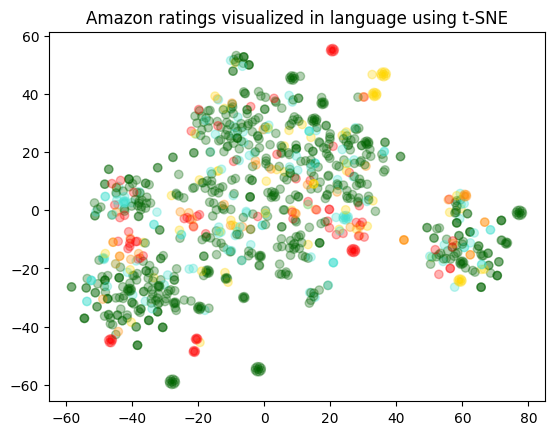

In [37]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

In [38]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
# 定义计算余弦相似度的函数

#计算向量 a 和 b 的点积（dot product），然后除以它们的范数（norm）的乘积

def cosine_similarity(vector_a, vector_b):
  dot_product = np.dot(vector_a, vector_b) # 计算向量的点积
  norm_a = np.linalg.norm(vector_a) # 计算向量1的模
  norm_b = np.linalg.norm(vector_b) # 计算向量2的模
  epsilon = 1e-10 # 防止出现除零错误
  cosine_similarity = dot_product / (norm_a * norm_b + epsilon) # 计算余弦相似度
  return cosine_similarity

In [45]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, product_description, n=3, pprint=True):
    #获取传入的产品描述的向量
    product_embedding = get_model_embedding(product_description)
    #计算相似度
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))
    
    print(df.sort_values("similarity", ascending=False, inplace=True))


    #替换字符串
    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

None
Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [42]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embedded, 'delicious beans', n=3)

Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [46]:
res = search_reviews(df_embedded, 'dog food', n=3)

None
Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!



In [47]:
res = search_reviews(df_embedded, 'awful', n=5)

None
God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  On

Disappointed:  The metal cover has severely disformed. And most of the cookies inside have been crushed into small pieces. Shopping experience is awful. I'll never buy it online again.

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate a

Arrived in pieces:  Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.

Awesome:  They arrived before the expected time and were of fantastic quality. Would recommend to any one looking for a awesome treat



In [48]:
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_model_embedding(product_description)

    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!



In [64]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42, n_init=10)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_


d:\python_env\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [65]:
df_embedded['Cluster']

937    2
474    3
940    0
1      3
543    3
      ..
435    2
332    1
526    2
834    0
351    2
Name: Cluster, Length: 1000, dtype: int32

In [66]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,similarity,Cluster
937,B001LUM1ZU,A3HJN5HU71FQIT,1,God Awful,As a dabbler who enjoys spanning the entire sp...,Title: God Awful; Content: As a dabbler who en...,122,"[-0.016613265499472618, -0.015883902087807655,...","[-0.016613265499472618, -0.015883902087807655,...",0.76210,2
474,B00196P9PA,A3D9688QO6PLGD,1,Disappointed,The metal cover has severely disformed. And mo...,Title: Disappointed; Content: The metal cover ...,41,"[-0.026066014543175697, -0.008565697818994522,...","[-0.026066014543175697, -0.008565697818994522,...",0.75736,3


d:\python_env\py310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\python_env\py310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


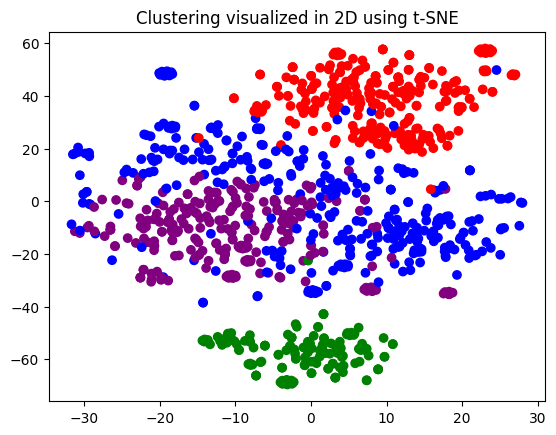

In [67]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()